There have been many discussions about links between samples in the train and test data, because the robot's absolute orientation does not change much in one run. This means that a) it is dangerously easy to create a model which looks like it predicts surfaces when in fact it predicts orientation and b) we might gain some additional knowledge about the data.

Let's settle this once and for all.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First, let's get our raw data:

In [2]:
train_X = pd.read_csv('X_train.csv').iloc[:,3:].values.reshape(-1,128,10)
test_X  = pd.read_csv('X_test.csv' ).iloc[:,3:].values.reshape(-1,128,10)
print('train_X shape:', train_X.shape, ', test_X shape:', test_X.shape)

train_X shape: (3810, 128, 10) , test_X shape: (3816, 128, 10)


...and y / group data:

In [3]:
df_train_y = pd.read_csv('y_train.csv')

# build a dict to convert surface names into numbers
surface_names = df_train_y['surface'].unique()
num_surfaces = len(surface_names)
surface_to_numeric = dict(zip(surface_names, range(num_surfaces)))
print('Convert to numbers: ', surface_to_numeric)

# y and group data as numeric values:
train_y = df_train_y['surface'].replace(surface_to_numeric).values
train_group = df_train_y['group_id'].values

Convert to numbers:  {'fine_concrete': 0, 'concrete': 1, 'soft_tiles': 2, 'tiled': 3, 'soft_pvc': 4, 'hard_tiles_large_space': 5, 'carpet': 6, 'hard_tiles': 7, 'wood': 8}


Let's plot the 4 orientation channels of a random group in series:

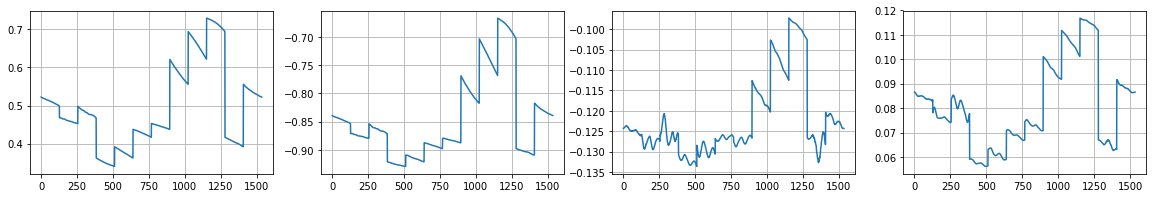

In [4]:
fig, axes = plt.subplots(1,4)
fig.set_size_inches(20,3)

for i in range(4):
    axes[i].plot(train_X[train_group == 17][:,:,i].reshape(-1))
    axes[i].grid(True)

Well, that certainly looks like a jigsaw puzzle to me. And that leads to an idea: the euclidean distance in the 4-dimensional "orientation space" between, for example, the right edge of one sample and the left edge of its true neighbor should be a minimum, *ideally even among all samples*, not only the samples in its group. Same for left/right. This should enable us to stitch the runs together again. All we have to do is link samples together which are *each other's* closest neighbors. Let's code:

In [5]:
def sq_dist(a,b):
    ''' the squared euclidean distance between two samples '''
    
    return np.sum((a-b)**2, axis=1)


def find_run_edges(data, edge):
    ''' examine links between samples. left/right run edges are those samples which do not have a link on that side. '''

    if edge == 'left':
        border1 = 0
        border2 = -1
    elif edge == 'right':
        border1 = -1
        border2 = 0
    else:
        return False
    
    edge_list = []
    linked_list = []
    
    for i in range(len(data)):
        dist_list = sq_dist(data[i, border1, :4], data[:, border2, :4]) # distances to rest of samples
        min_dist = np.min(dist_list)
        closest_i   = np.argmin(dist_list) # this is i's closest neighbor
        if closest_i == i: # this might happen and it's definitely wrong
            print('Sample', i, 'linked with itself. Next closest sample used instead.')
            closest_i = np.argsort(dist_list)[1]
        dist_list = sq_dist(data[closest_i, border2, :4], data[:, border1, :4]) # now find closest_i's closest neighbor
        rev_dist = np.min(dist_list)
        closest_rev = np.argmin(dist_list) # here it is
        if closest_rev == closest_i: # again a check
            print('Sample', i, '(back-)linked with itself. Next closest sample used instead.')
            closest_rev = np.argsort(dist_list)[1]
        if (i != closest_rev): # we found an edge
            edge_list.append(i)
        else:
            linked_list.append([i, closest_i, min_dist])
            
    return edge_list, linked_list


def find_runs(data, left_edges, right_edges):
    ''' go through the list of samples & link the closest neighbors into a single run '''
    
    data_runs = []

    for start_point in left_edges:
        i = start_point
        run_list = [i]
        while i not in right_edges:
            tmp = np.argmin(sq_dist(data[i, -1, :4], data[:, 0, :4]))
            if tmp == i: # self-linked sample
                tmp = np.argsort(sq_dist(data[i, -1, :4], data[:, 0, :4]))[1]
            i = tmp
            run_list.append(i)
        data_runs.append(np.array(run_list))
    
    return data_runs

Let's go:

In [251]:
train_left_edges, train_left_linked  = find_run_edges(train_X, edge='left')
train_right_edges, train_right_linked = find_run_edges(train_X, edge='right')
print('Found', len(train_left_edges), 'left edges and', len(train_right_edges), 'right edges.')

Sample 1 (back-)linked with itself. Next closest sample used instead.
Sample 216 linked with itself. Next closest sample used instead.
Sample 335 linked with itself. Next closest sample used instead.
Sample 748 (back-)linked with itself. Next closest sample used instead.
Sample 799 linked with itself. Next closest sample used instead.
Sample 1205 linked with itself. Next closest sample used instead.
Sample 1913 linked with itself. Next closest sample used instead.
Sample 1986 linked with itself. Next closest sample used instead.
Sample 2555 linked with itself. Next closest sample used instead.
Sample 2612 linked with itself. Next closest sample used instead.
Sample 2761 linked with itself. Next closest sample used instead.
Sample 2917 linked with itself. Next closest sample used instead.
Sample 3312 linked with itself. Next closest sample used instead.
Sample 181 linked with itself. Next closest sample used instead.
Sample 272 linked with itself. Next closest sample used instead.
Sampl

Well, that certainly looks promising. Found 76 runs, similar number than the number of groups. Build the runs:

In [252]:
train_runs = find_runs(train_X, train_left_edges, train_right_edges)

Have we found all samples? Have we used any sample twice? The answer is yes, and no. Perfect.

In [253]:
flat_list = [series_id for run in train_runs for series_id in run]
print(len(flat_list), len(np.unique(flat_list)))

3810 3810


Now for the real test. How many different surfaces are in each run? *Only 4 runs have more than one surface* (and if you look at them, you can easily split them by hand). This actually works!

In [254]:
print([ len(np.unique(train_y[run])) for run in train_runs ])

[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1]


Interesting. Some runs contain  2, 3 and even 4 groups. So several groups were cut from one run:

In [255]:
print([ len(np.unique(train_group[run])) for run in train_runs ])

[2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 4, 1, 1, 2, 1, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1]


Let's plot all 10 channels for one run.  Beautiful.

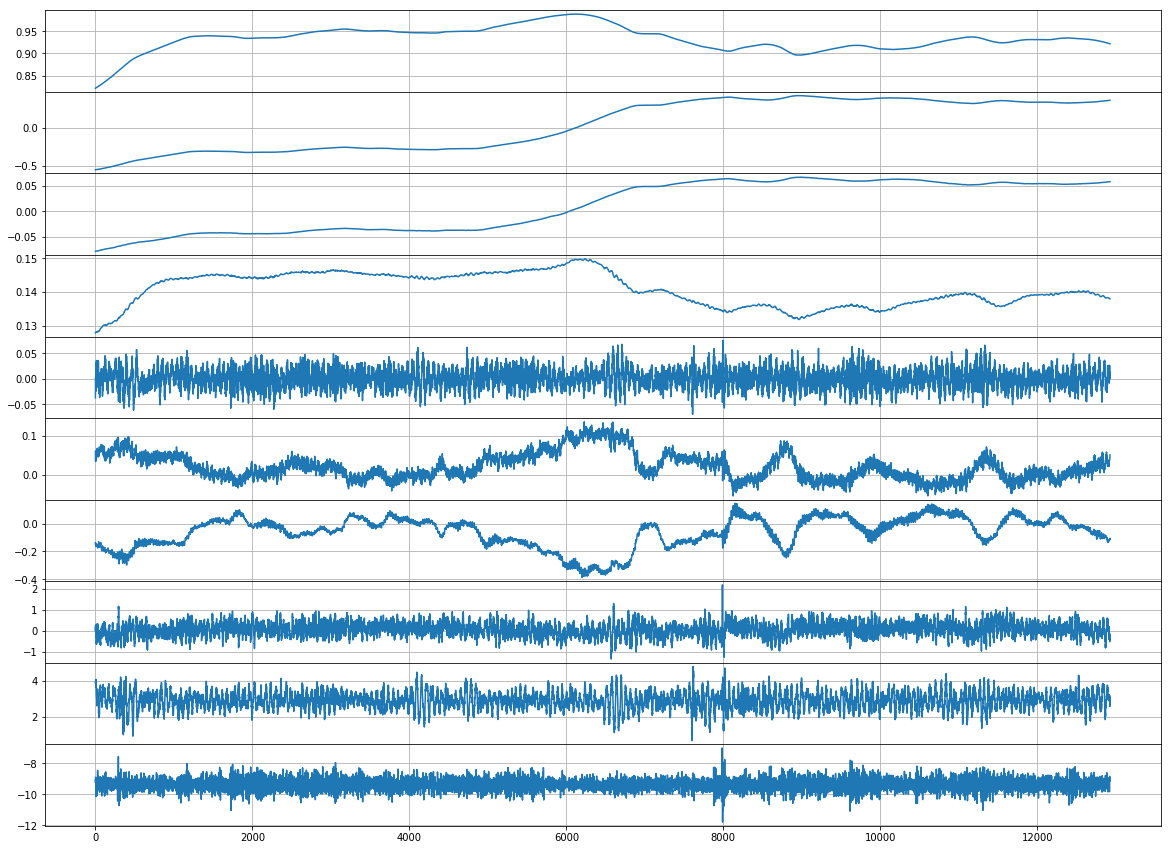

In [256]:
fig, axes = plt.subplots(10,1, sharex=True)
fig.set_size_inches(20,15)
fig.subplots_adjust(hspace=0)

for i in range(10):
    axes[i].plot(train_X[train_runs[0]][:,:,i].reshape(-1))
    axes[i].grid(True)

Let's add our new knowledge to train_y. Now you can use this info to train your models to even greater perfection. Enjoy!

In [257]:
df_train_y['run_id'] = 0
df_train_y['run_pos'] = 0

for run_id in range(len(train_runs)):
    for run_pos in range(len(train_runs[run_id])):
        series_id = train_runs[run_id][run_pos]
        df_train_y.at[ series_id, 'run_id'  ] = run_id
        df_train_y.at[ series_id, 'run_pos' ] = run_pos

df_train_y.to_csv('y_train_with_runs.csv', index=False)
df_train_y.tail()

series_id  group_id        surface  run_id  run_pos
3805       3805        55          tiled      46        4
3806       3806        67           wood      74        2
3807       3807        48  fine_concrete      65       57
3808       3808        54          tiled      54       97
3809       3809        56       soft_pvc      69      123

...But wait. Might this also work with the test data?

In [258]:
test_left_edges, test_left_linked  = find_run_edges(test_X, edge='left')
test_right_edges, test_right_linked = find_run_edges(test_X, edge='right')
print('Found', len(test_left_edges), 'left edges and', len(test_right_edges), 'right edges.')

Sample 355 linked with itself. Next closest sample used instead.
Sample 580 linked with itself. Next closest sample used instead.
Sample 1402 linked with itself. Next closest sample used instead.
Sample 1547 linked with itself. Next closest sample used instead.
Sample 1716 linked with itself. Next closest sample used instead.
Sample 2136 (back-)linked with itself. Next closest sample used instead.
Sample 2474 linked with itself. Next closest sample used instead.
Sample 2495 (back-)linked with itself. Next closest sample used instead.
Sample 2600 linked with itself. Next closest sample used instead.
Sample 2922 linked with itself. Next closest sample used instead.
Sample 580 linked with itself. Next closest sample used instead.
Sample 1216 linked with itself. Next closest sample used instead.
Sample 1409 linked with itself. Next closest sample used instead.
Sample 1410 linked with itself. Next closest sample used instead.
Sample 1670 linked with itself. Next closest sample used instead.

Oh yeah!

In [259]:
test_runs = find_runs(test_X, test_left_edges, test_right_edges)

Again no samples are used twice, but we have lost some.

In [260]:
flat_list = [series_id for run in test_runs for series_id in run]
print(len(flat_list), len(np.unique(flat_list)))

3790 3790


 3816 - 3790 = 26 samples are not in any run and aren't edges. They must form a closed ring -> another run. find it:

In [261]:
lost_samples = np.array([ i for i in range(len(test_X)) if i not in np.concatenate(test_runs) ])
print(lost_samples)
print(len(lost_samples))

[ 264  361  529  620  733  954 1148 1248 1432 1534 1570 1738 1739 2090
 2205 2714 2847 2978 2991 3115 3173 3183 3195 3359 3517 3655]
26


In [262]:
find_run_edges(test_X[lost_samples], edge='left')[1][0]

[0, 5, 2.0548399999999954e-07]

In [263]:
lost_run = np.array(lost_samples[find_runs(test_X[lost_samples], [0], [5])[0]])
test_runs.append(lost_run)

Perfect. Now we also have test runs. A nice plot to prove it:

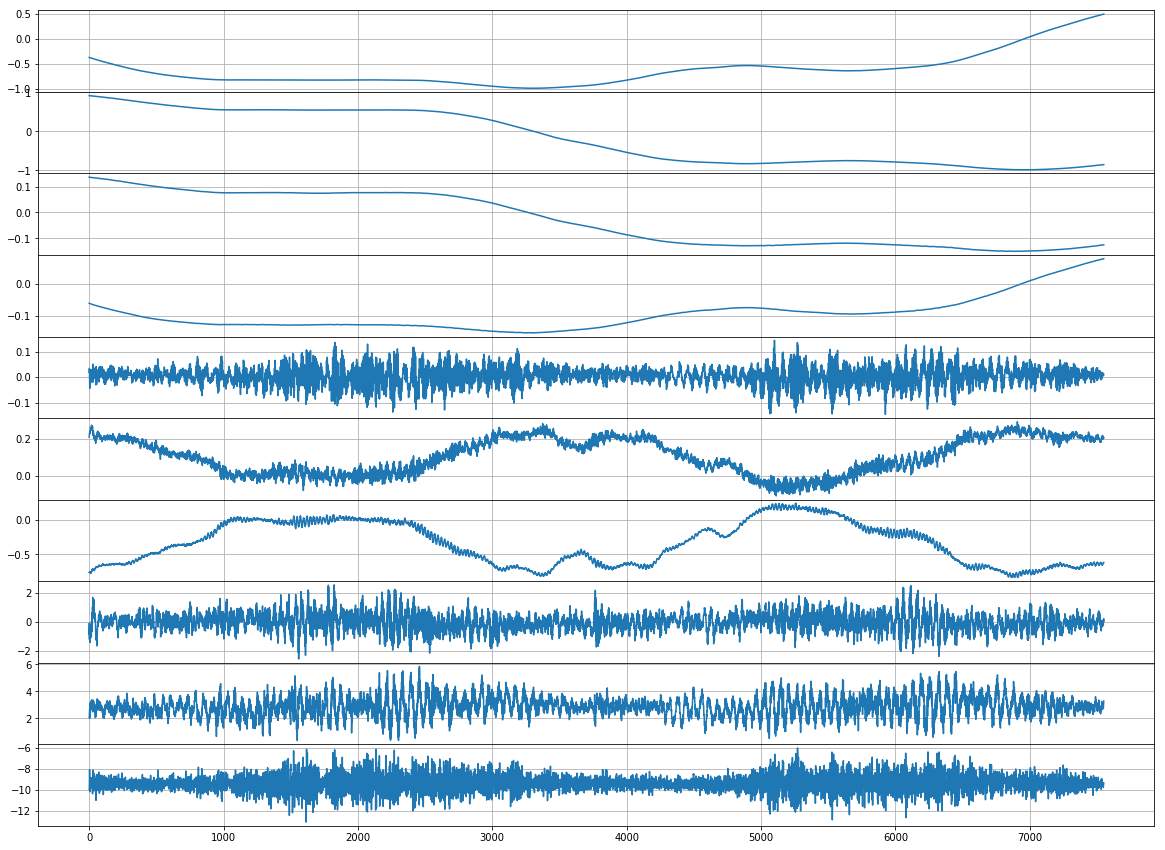

In [264]:
fig, axes = plt.subplots(10,1, sharex=True)
fig.set_size_inches(20,15)
fig.subplots_adjust(hspace=0)

for i in range(10):
    axes[i].plot(test_X[test_runs[1]][:,:,i].reshape(-1))
    axes[i].grid(True)

In [291]:
df_test_y = pd.read_csv('X_test.csv')
df = df_test_y['series_id'].unique()
dfa = pd.DataFrame(df)
dfa.columns = ['series_id']
dfa.head()

series_id
0          0
1          1
2          2
3          3
4          4

In [292]:
dfa['run_id'] = 0
dfa['run_pos'] = 0

for run_id in range(len(test_runs)):
    for run_pos in range(len(test_runs[run_id])):
        series_id = test_runs[run_id][run_pos]
        dfa.at[ series_id, 'run_id'  ] = run_id
        dfa.at[ series_id, 'run_pos' ] = run_pos

# df_train_y.to_csv('y_train_with_runs.csv', index=False)
dfa

series_id  run_id  run_pos
0             0      14       19
1             1      57        8
2             2      42       13
3             3      65       11
4             4      68        3
5             5      60       17
6             6      29       13
7             7      34       31
8             8       1        6
9             9      61      164
10           10      29       41
11           11      71       51
12           12      62       12
13           13       0       94
14           14      46       52
15           15      62       18
16           16       4        1
17           17      51      111
18           18      28       16
19           19      27       69
20           20      61       17
21           21      61       65
22           22      29       21
23           23      70        2
24           24      59        8
25           25       1       58
26           26      30       43
27           27      71       11
28           28      61       81
29           29      34      118
...         ...     ...      ...
3786       3786      71        0
3787       3787      57       55
3788       3788      72        0
3789       3789      47       18
3790       3790      63        5
3791       3791      73        0
3792       3792      39       44
3793       3793      19       53
3794       3794      58       32
3795       3795      28       10
3796       3796       0      150
3797       3797      58       76
3798       3798      74        0
3799       3799      21        9
3800       3800       6       10
3801       3801      61      162
3802       3802      39       77
3803       3803       7        1
3804       3804      58      106
3805       3805      61       26
3806       3806      59       10
3807       3807      49       53
3808       3808       3       60
3809       3809      40       72
3810       3810      29       91
3811       3811      36       16
3812       3812      65       23
3813       3813      72        3
3814       3814      57       11
3815       3815      32       14

[3816 rows x 3 columns]

In [293]:
dfa['surface'] = 'empty'

In [295]:
dfa[dfa['run_id']==0].head()

series_id  run_id  run_pos surface
13          13       0       94   empty
45          45       0        0   empty
51          51       0       10   empty
167        167       0      138   empty
197        197       0       98   empty

In [296]:
dfa[dfa['run_id']==0].head()

series_id  run_id  run_pos surface
13          13       0       94   empty
45          45       0        0   empty
51          51       0       10   empty
167        167       0      138   empty
197        197       0       98   empty

In [274]:
df_train_y[df_train_y['run_id']==0]

series_id  group_id     surface  run_id  run_pos
19           19         9  soft_tiles       0        0
24           24         9  soft_tiles       0       25
30           30         9  soft_tiles       0       19
31           31         9  soft_tiles       0       43
52           52         9  soft_tiles       0       26
80           80         9  soft_tiles       0       17
88           88         9  soft_tiles       0        6
106         106         4  soft_tiles       0       83
114         114         4  soft_tiles       0       61
129         129         4  soft_tiles       0       49
135         135         4  soft_tiles       0       48
136         136         4  soft_tiles       0       78
137         137         9  soft_tiles       0       10
140         140         4  soft_tiles       0       92
150         150         9  soft_tiles       0       13
240         240         4  soft_tiles       0       84
253         253         9  soft_tiles       0       15
258         258         4  soft_tiles       0       96
291         291         4  soft_tiles       0       80
293         293         9  soft_tiles       0       34
298         298         4  soft_tiles       0       65
307         307         4  soft_tiles       0       73
321         321         4  soft_tiles       0       45
348         348         4  soft_tiles       0       77
370         370         9  soft_tiles       0       24
372         372         9  soft_tiles       0       11
406         406         4  soft_tiles       0       54
440         440         9  soft_tiles       0       36
445         445         9  soft_tiles       0       23
452         452         9  soft_tiles       0        3
...         ...       ...         ...     ...      ...
1268       1268         4  soft_tiles       0       87
1314       1314         4  soft_tiles       0       99
1327       1327         4  soft_tiles       0       66
1337       1337         4  soft_tiles       0       71
1342       1342         4  soft_tiles       0       74
1357       1357         9  soft_tiles       0       27
1362       1362         4  soft_tiles       0       64
1375       1375         4  soft_tiles       0       89
1378       1378         9  soft_tiles       0       16
1396       1396         4  soft_tiles       0       57
1474       1474         9  soft_tiles       0        8
1487       1487         9  soft_tiles       0       41
1491       1491         4  soft_tiles       0       75
1497       1497         9  soft_tiles       0       32
1503       1503         9  soft_tiles       0       40
1517       1517         4  soft_tiles       0       98
1530       1530         4  soft_tiles       0       69
1549       1549         4  soft_tiles       0       72
1551       1551         9  soft_tiles       0       37
1582       1582         9  soft_tiles       0       35
1601       1601         4  soft_tiles       0       50
1622       1622         4  soft_tiles       0       44
1624       1624         9  soft_tiles       0       29
1627       1627         4  soft_tiles       0       60
1643       1643         9  soft_tiles       0        5
1675       1675         4  soft_tiles       0       95
1676       1676         4  soft_tiles       0       81
1677       1677         4  soft_tiles       0       97
1680       1680         9  soft_tiles       0        2
1682       1682         4  soft_tiles       0       68

[101 rows x 5 columns]

I'll leave you with a caution and an exercise:
First, there are certainly some errors in the test runs. Two runs with different surfaces might have been stitched into one (as happened 4 times with the train data) by chance.
Second, might it even be possible to link *across train and test*? Well, see for yourself...

In [6]:
df_test_y = pd.read_csv('X_test.csv')

In [7]:
df_test_y['series_id'] = df_test_y['series_id'] + 3810

In [8]:
df = df_test_y['series_id'].unique()

In [9]:
dfa = pd.DataFrame(df)

In [10]:
dfa.columns = ['series_id']

In [11]:
dfa.head()

series_id
0       3810
1       3811
2       3812
3       3813
4       3814

In [12]:
dfa['surface'] = 'empty'

In [14]:
df_train_y = pd.concat([df_train_y, dfa], ignore_index=True)

c:\users\doomb\anaconda3\envs\capstone2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [15]:
df_train_y = df_train_y.drop(['group_id'], axis=1)

In [16]:
total_X = np.append(train_X, test_X, axis=0)

In [17]:
total_X.shape

(7626, 128, 10)

In [18]:
total_left_edges, total_left_linked  = find_run_edges(total_X, edge='left')
total_right_edges, total_right_linked = find_run_edges(total_X, edge='right')
print('Found', len(total_left_edges), 'left edges and', len(total_right_edges), 'right edges.')

Sample 1 (back-)linked with itself. Next closest sample used instead.
Sample 216 linked with itself. Next closest sample used instead.
Sample 748 (back-)linked with itself. Next closest sample used instead.
Sample 799 linked with itself. Next closest sample used instead.
Sample 1913 linked with itself. Next closest sample used instead.
Sample 2555 linked with itself. Next closest sample used instead.
Sample 2612 linked with itself. Next closest sample used instead.
Sample 2917 linked with itself. Next closest sample used instead.
Sample 3312 linked with itself. Next closest sample used instead.
Sample 4165 linked with itself. Next closest sample used instead.
Sample 5212 linked with itself. Next closest sample used instead.
Sample 5946 (back-)linked with itself. Next closest sample used instead.
Sample 6305 (back-)linked with itself. Next closest sample used instead.
Sample 181 linked with itself. Next closest sample used instead.
Sample 464 linked with itself. Next closest sample used

In [19]:
total_runs = find_runs(total_X, total_left_edges, total_right_edges)

In [20]:
flat_list = [series_id for run in total_runs for series_id in run]
print(len(flat_list), len(np.unique(flat_list)))

7600 7600


In [21]:
lost_samples = np.array([ i for i in range(len(total_X)) if i not in np.concatenate(total_runs) ])
print(lost_samples)
print(len(lost_samples))

[4074 4171 4339 4430 4543 4764 4958 5058 5242 5344 5380 5548 5549 5900
 6015 6524 6657 6788 6801 6925 6983 6993 7005 7169 7327 7465]
26


In [22]:
find_run_edges(total_X[lost_samples], edge='left')[1][0]

[0, 5, 2.0548399999999954e-07]

In [23]:
lost_run = np.array(lost_samples[find_runs(total_X[lost_samples], [0], [5])[0]])
total_runs.append(lost_run)

In [28]:
# df_train_y['run_id'] = 0
# df_train_y['run_pos'] = 0

# for run_id in range(len(total_runs)):
#     for run_pos in range(len(total_runs[run_id])):
#         series_id = total_runs[run_id][run_pos]
#         df_train_y.at[ series_id, 'run_id'  ] = run_id
#         df_train_y.at[ series_id, 'run_pos' ] = run_pos

df_train_y.to_csv('y_total_with_runs.csv', index=False)
# df_train_y.tail()

In [ ]:
for run_id in range(len(df_train_y)):
    for run_pos in range(len(df_train_y[df_train_y]))

In [26]:
df_train_y

series_id                 surface  run_id  run_pos
0             0           fine_concrete     101      159
1             1                concrete      24       14
2             2                concrete       5        4
3             3                concrete      24       42
4             4              soft_tiles      87      164
5             5                   tiled     148      128
6             6                soft_pvc      18       26
7             7                concrete      24       49
8             8  hard_tiles_large_space       6       13
9             9                   tiled     148       93
10           10                soft_pvc      11      149
11           11                   tiled     148      136
12           12                  carpet     141       25
13           13                  carpet     141       29
14           14                concrete      96      116
15           15                  carpet     136       56
16           16                  carpet     136       76
17           17              soft_tiles      22       43
18           18                   tiled      21       75
19           19              soft_tiles       0        0
20           20                   tiled     148       90
21           21  hard_tiles_large_space       6        5
22           22              soft_tiles      87      192
23           23                   tiled      21       23
24           24              soft_tiles       0       25
25           25              soft_tiles      87       40
26           26           fine_concrete     101      167
27           27              hard_tiles     118      111
28           28                   tiled     148       81
29           29  hard_tiles_large_space       6       15
...         ...                     ...     ...      ...
7596       7596                   empty     148        0
7597       7597                   empty     139       43
7598       7598                   empty     149        0
7599       7599                   empty     128       18
7600       7600                   empty     143        5
7601       7601                   empty     150        0
7602       7602                   empty     118       44
7603       7603                   empty     101      127
7604       7604                   empty      96       14
7605       7605                   empty      31      135
7606       7606                   empty     147       17
7607       7607                   empty      96       58
7608       7608                   empty      68       11
7609       7609                   empty      42       24
7610       7610                   empty      87       10
7611       7611                   empty      56       21
7612       7612                   empty     118       77
7613       7613                   empty      88        1
7614       7614                   empty      96       88
7615       7615                   empty      75       32
7616       7616                   empty       8       17
7617       7617                   empty     145       33
7618       7618                   empty      36      142
7619       7619                   empty     119       72
7620       7620                   empty     108       91
7621       7621                   empty      16       19
7622       7622                   empty      31       34
7623       7623                   empty     149        3
7624       7624                   empty      24       65
7625       7625                   empty      61       28

[7626 rows x 4 columns]

In [27]:
df_train_y[df_train_y['run_id']==0]

series_id     surface  run_id  run_pos
19           19  soft_tiles       0        0
24           24  soft_tiles       0       25
30           30  soft_tiles       0       19
31           31  soft_tiles       0       43
52           52  soft_tiles       0       26
80           80  soft_tiles       0       17
88           88  soft_tiles       0        6
106         106  soft_tiles       0       83
114         114  soft_tiles       0       61
129         129  soft_tiles       0       49
135         135  soft_tiles       0       48
136         136  soft_tiles       0       78
137         137  soft_tiles       0       10
140         140  soft_tiles       0       92
150         150  soft_tiles       0       13
240         240  soft_tiles       0       84
253         253  soft_tiles       0       15
258         258  soft_tiles       0       96
291         291  soft_tiles       0       80
293         293  soft_tiles       0       34
298         298  soft_tiles       0       65
307         307  soft_tiles       0       73
321         321  soft_tiles       0       45
348         348  soft_tiles       0       77
370         370  soft_tiles       0       24
372         372  soft_tiles       0       11
406         406  soft_tiles       0       54
440         440  soft_tiles       0       36
445         445  soft_tiles       0       23
452         452  soft_tiles       0        3
...         ...         ...     ...      ...
6646       6646       empty       0      110
6693       6693       empty       0      174
6706       6706       empty       0      211
6775       6775       empty       0      156
6818       6818       empty       0      103
6867       6867       empty       0      159
6886       6886       empty       0      216
6890       6890       empty       0      182
6894       6894       empty       0      133
6923       6923       empty       0      199
6961       6961       empty       0      149
7035       7035       empty       0      141
7037       7037       empty       0      107
7041       7041       empty       0      109
7045       7045       empty       0      137
7060       7060       empty       0      116
7136       7136       empty       0      198
7178       7178       empty       0      108
7207       7207       empty       0      226
7250       7250       empty       0      183
7359       7359       empty       0      147
7364       7364       empty       0      223
7375       7375       empty       0      150
7378       7378       empty       0      148
7398       7398       empty       0      210
7445       7445       empty       0      189
7516       7516       empty       0      202
7538       7538       empty       0      175
7539       7539       empty       0      117
7584       7584       empty       0      191

[227 rows x 4 columns]